<a href="https://colab.research.google.com/github/greymouse1/spatialanalysis/blob/main/continuity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code is licenced under MIT licence.

Author: Nikola G.

Credits:

Tutorial from Momepy package website at http://docs.momepy.org/en/stable/user_guide/graph/coins.html
based on paper by Tripathy et al. (2020)

OpenAI. (2024). ChatGPT (version 4) [Large language model]. OpenAI. https://openai.com/chatgpt



Tripathy, P., Rao, P., Balakrishnan, K., & Malladi, T. (2020). An open-source tool to extract natural continuity and hierarchy of urban street networks. Environment and Planning B: Urban Analytics and City Science. http://dx.doi.org/10.1177/2399808320967680

In [1]:
!pip install osmnx > /dev/null 2>&1
!pip install momepy > /dev/null 2>&1
!pip install mapclassify>=2.4.0 > /dev/null 2>&1 # install mapclassify with version >=2.4.0
!pip install powerlaw > /dev/null 2>&1
import osmnx as ox
import geopandas as gpd
import momepy
import mapclassify
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Load shp file with city polygon boundary (WGS84)

bandung_pol = gpd.read_file("/content/bandung_pol/bandung_pol.shp").geometry.iloc[0]

In [3]:
# Retrieve the graph within the polygon's boundaries
# This will pull OSM data from inside the polygon and create a networkX graph

graph = ox.graph_from_polygon(
    bandung_pol,
    network_type='drive',  # Choose network type (e.g., 'drive', 'walk', 'bike', etc.)
    simplify=True,         # Simplify graph (remove unnecessary nodes)
    retain_all=False,      # Keep only the largest connected component
    truncate_by_edge=False  # Truncate by edge to keep nodes near the edge
)


In [4]:
# Reproject graph
# Choice of final projection is automatic, original must be WGS84

bandung_streets = ox.projection.project_graph(graph)

In [5]:
# Create gdf from graph so it can be used later on

bandung_gdf = ox.graph_to_gdfs(
    ox.convert.to_undirected(bandung_streets),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True,
)

Calculating best minimal value for power law fit
Alpha: 5.326668187046868
xmin: 26.0
p-value: 0.037455027472507174
-----------------------
Log-likelihood ratio (R): 9.514206266853332
p-value for comparison: 0.006087914652839443


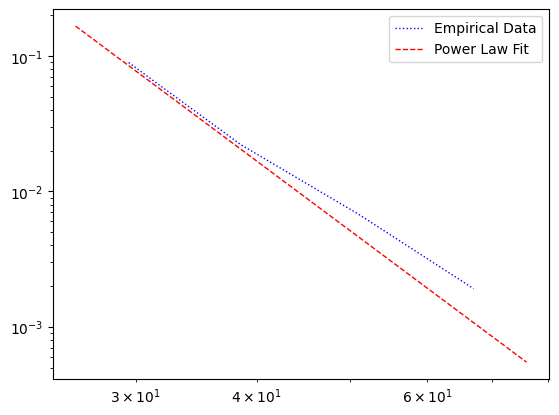

In [44]:
# Assuming bandung_gdf is your GeoDataFrame with edges as LineStrings
# Calculate the degree as the number of vertices (nodes) in each LineString
bandung_gdf["degree"] = bandung_gdf["geometry"].apply(lambda line: len(line.coords) if line else 0)

# Extract degree values
degree_values = bandung_gdf["degree"].tolist()

# Count frequencies of degree values
degree_counts = Counter(degree_values)

# Extract x (degrees) and y (frequencies)
x = np.array(list(degree_counts.keys()))       # Unique degree values
y = np.array(list(degree_counts.values()))    # Frequency of each degree

# Fit the degree distribution to a power-law model
fit = powerlaw.Fit(degree_values)
print(f"Alpha: {fit.alpha}")
print(f"xmin: {fit.xmin}")

# Get alpha and xmin (scaling parameter and lower bound for the power-law fit)
# Value beyong x-min follows power law distribution, portion of the tail
alpha = fit.alpha
xmin = fit.xmin

# Get the p-value from the goodness-of-fit test
p_value = fit.power_law.KS()

print(f"p-value: {p_value}")
print("-----------------------")
# Compare the power-law fit with an alternative distribution (e.g., exponential)
R, p_alt = fit.distribution_compare('power_law', 'exponential')
print(f"Log-likelihood ratio (R): {R}")
print(f"p-value for comparison: {p_alt}")

# Plot the data and the fitted power law
fig = fit.plot_pdf(color='blue', linestyle='dotted', linewidth=1, label='Empirical Data')
fit.power_law.plot_pdf(ax=fig, color='r', linestyle='--', linewidth=1, label='Power Law Fit')

# Add legend and labels
plt.legend()
plt.show()

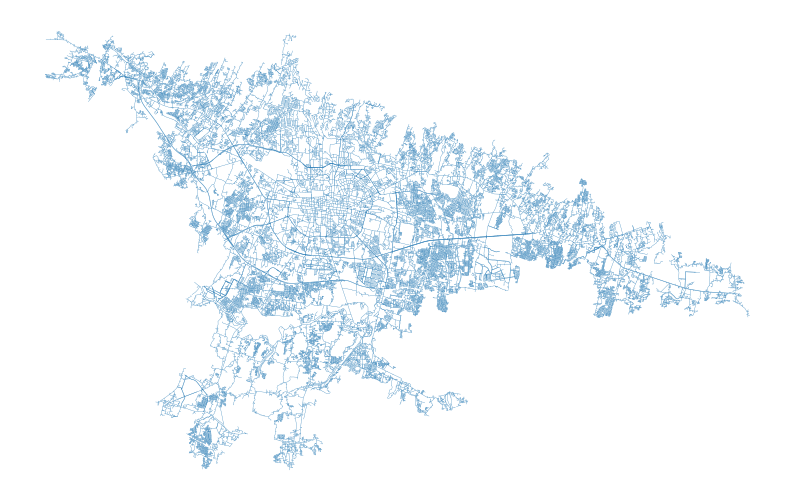

In [13]:
# Plot downloaded OSM roads

bandung_gdf.plot(figsize=(10, 10), linewidth=0.2).set_axis_off()

In [ ]:
# Calculate continuity from the gdf

continuity = momepy.COINS(bandung_gdf, angle_threshold=135, flow_mode=False)

In [ ]:
# Pull out stroke

bandung_stroke_gdf = continuity.stroke_gdf()

In [ ]:
# Pull n_segments out of the gdf
n_segments = bandung_stroke_gdf['n_segments']

# Calculate heavy tailed classification
classifier = mapclassify.HeadTailBreaks(n_segments)

# Show the classifier (lower and upper bounds plus count)
print(classifier)

bandung_stroke_gdf.plot(
    figsize=(15, 15),
    cmap="viridis_r",
    column="n_segments",
    legend=True,
    linewidth=0.3,
    scheme="headtailbreaks",
).set_axis_off()

In [ ]:
# Histogram for n_segments

from matplotlib import pyplot as plt
bandung_stroke_gdf['n_segments'].plot(kind='hist', bins=40, title='n_segments')
plt.gca().spines[['top', 'right',]].set_visible(False)